# Parameter Correlations and Scatter Plot Analysis

In [3]:
# Import third party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import circmean
import os

The following notebook will explore correlations between the weather, air quality, drilling and production data. The analysis will include exploration of daily measurements as well as monthly measurements.

## Exploring Parameter Correlations
The four sets of data must be combined into one data frame. As the wind direction is given in degrees, to aggregate the wind direction from hourly to daily a circular mean must be used to account for the angularity of the parameter.

In [4]:
# Define file paths using os
# Path of working directory
working_path = os.path.abspath(os.getcwd())

# Path of parent directory
path_one_level_back = os.path.dirname(working_path)

# Define paths for weather files
weather = os.path.join(path_one_level_back, '2-Analysis', 'weather_data.csv')
air_quality = os.path.join(path_one_level_back, '2-Analysis', 'FarmingtonCommunityHall_AQ.csv')
drilling = os.path.join(path_one_level_back, '2-Analysis', 'drill_final.csv')
production = os.path.join(path_one_level_back, '2-Analysis', 'production_daily.csv')

# Read in cleaned weather, air quality, drilling, and production files
AQ_data = pd.read_csv(air_quality)
weather_data = pd.read_csv(weather)
drill_data = pd.read_csv(drilling)
production_data_daily = pd.read_csv(production)


# Combine cleaned weather and air quality files into one dataframe
AQ_weather_hourly = weather_data.merge(right=AQ_data,
                                     how='inner')
# Reset DateTimeIndex
AQ_weather_hourly = AQ_weather_hourly.set_index(pd.DatetimeIndex(AQ_weather_hourly['Datetime']))
AQ_weather_hourly.drop('Datetime', axis=1, inplace=True)

# Resample AQ and weather to daily
# Resample by taking the mean value per day
AQ_weather_daily = AQ_weather_hourly.resample('D').mean()

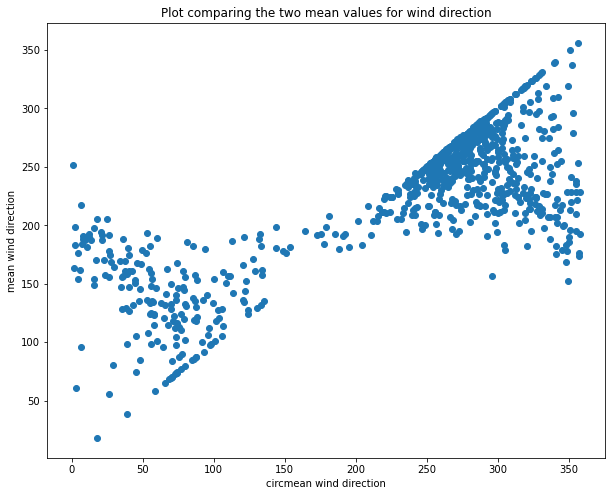

In [5]:
# Use scipy.stats.circmean to compute the circular mean for the samples

# Filter out wind direction to apply a circular mean when resampling to daily
WDIR = AQ_weather_hourly.filter(['WDIR_VECT_(DEG)'], axis=1)

def circular_mean(x):
    return round(np.rad2deg(circmean(np.deg2rad(x['WDIR_VECT_(DEG)'].values))),2)

WDIR_daily = WDIR.resample('D').apply(circular_mean)

# Plot the resample mean wind direction vs the circular mean wind direction
plt.figure(figsize=(10,8))
plt.title('Plot comparing the two mean values for wind direction')
plt.scatter(WDIR_daily, AQ_weather_daily['WDIR_VECT_(DEG)'])
plt.ylabel('mean wind direction')
plt.xlabel('circmean wind direction')
plt.show()

In [6]:
# Add circular mean rather than mean
AQ_weather_daily['WDIR_VECT_(DEG)'] = WDIR_daily
AQ_weather_daily.head()

,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3
Datetime,,,,,,,,,,
2019-01-01,2.879167,261.97,7.595833,68.220833,0.820833,0.333333,0.268750,0.543750,0.183333,37.122917
2019-01-02,4.066667,256.22,8.525000,64.683333,0.739583,0.283333,0.229167,0.510417,0.104167,37.287500
2019-01-03,-6.262500,290.07,2.079167,72.279167,6.056250,0.297917,0.677083,5.362500,0.110417,28.483333
2019-01-04,-7.912500,21.19,0.779167,88.525000,6.258333,0.687500,0.377083,5.879167,0.172917,24.160417
2019-01-05,-9.120833,65.03,1.870833,88.825000,5.381250,1.010417,0.737500,4.652083,0.139583,26.127083


In [7]:
# Combine daily weather, AQ and drilling and production

# Rename date columns to match AQ and weather and set as Datetime Index
drill_data.rename(columns={'Date':'Datetime'}, inplace=True)
drill_data = drill_data.set_index(pd.DatetimeIndex(drill_data['Datetime']))
drill_data.drop('Datetime', axis=1, inplace=True)

# Combine AQ, weather and drilling
AQ_weather_drilling_daily = AQ_weather_daily.merge(right=drill_data,
                                                  how='inner',
                                                  left_index=True,
                                                  right_index=True)

# Rename date columns to match AQ and weather and set as Datetime Index
production_data_daily.rename(columns={'Date':'Datetime'}, inplace=True)
production_data_daily = production_data_daily.set_index(pd.DatetimeIndex(production_data_daily['Datetime']))
production_data_daily.drop('Datetime', axis=1, inplace=True)

# Combine AQ, weather and drilling
AQ_weather_drilling_prod_daily = AQ_weather_drilling_daily.merge(right=production_data_daily,
                                                                 how='inner',
                                                                 left_index=True,
                                                                 right_index=True)

# Re-oder the columns of the dataframe so that drilling and gas production comes before AQ parameters
AQ_weather_drilling_prod_daily = AQ_weather_drilling_prod_daily[['TEMP_MEAN_(C)','WDIR_VECT_(DEG)','WSPD_SCLR_(M/S)','HUMIDITY_(%)','Depth_per_day','gas_prod_vol_m3','SO2','TRS','NOx','NO','NO2','O3']]

# View df
AQ_weather_drilling_prod_daily=AQ_weather_drilling_prod_daily.dropna(how='any', axis=0)
AQ_weather_drilling_prod_daily.head()

,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),Depth_per_day,gas_prod_vol_m3,SO2,TRS,NOx,NO,NO2,O3
Datetime,,,,,,,,,,,,
2019-01-01,2.879167,261.97,7.595833,68.220833,252.000000,168187.648387,0.333333,0.183333,0.820833,0.268750,0.543750,37.122917
2019-01-02,4.066667,256.22,8.525000,64.683333,252.000000,168187.648387,0.283333,0.104167,0.739583,0.229167,0.510417,37.287500
2019-01-03,-6.262500,290.07,2.079167,72.279167,588.502415,168187.648387,0.297917,0.110417,6.056250,0.677083,5.362500,28.483333
2019-01-04,-7.912500,21.19,0.779167,88.525000,807.002415,168187.648387,0.687500,0.172917,6.258333,0.377083,5.879167,24.160417
2019-01-05,-9.120833,65.03,1.870833,88.825000,807.002415,168187.648387,1.010417,0.139583,5.381250,0.737500,4.652083,26.127083


### Mean Daily Correlation

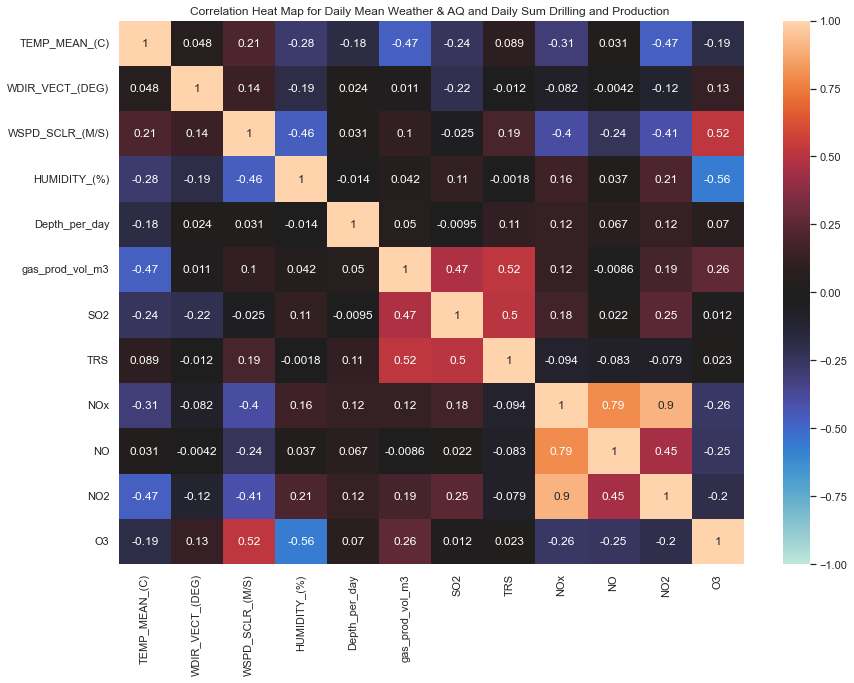

In [8]:
# Plot correlation heat map for all parameters using mean values for weather and AQ and summed values for drilling and production

plt.figure(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(AQ_weather_drilling_prod_daily.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Daily Mean Weather & AQ and Daily Sum Drilling and Production ')
plt.show()

From the above figure we see that:
NOx:
 - negatively correlated with temperature and wind speed. NOx is also correlated with NO and NO2
 - shows no correlations with oil and gas data

SO2:
 - negatively correlated with temperature and wind direction and positively correlated with TRS
 - shows a positive correlation with the gas production volumes

NO:
 - slight negative correlation with wind speed and a correlation with other N species

NO2:
 - negatively correlated with temperature and wind speed

TRS:
 - correlated with other sulphur species and with gas production volumes

O3:
 - positive correlation with windpeed, negative correlation with humidity
 - slight correlation with gas production volumes

### Mean Weekly Correlation
The daily values can then be resampled using the index into weekly and monthly mean datasets.For example, rather than comparing the monthly mean AQ and weather data to the total depth drilled and total gas produced in a month, the following figures will explore correlations between the mean AQ and weather data and the mean depth drilled and gas produced.

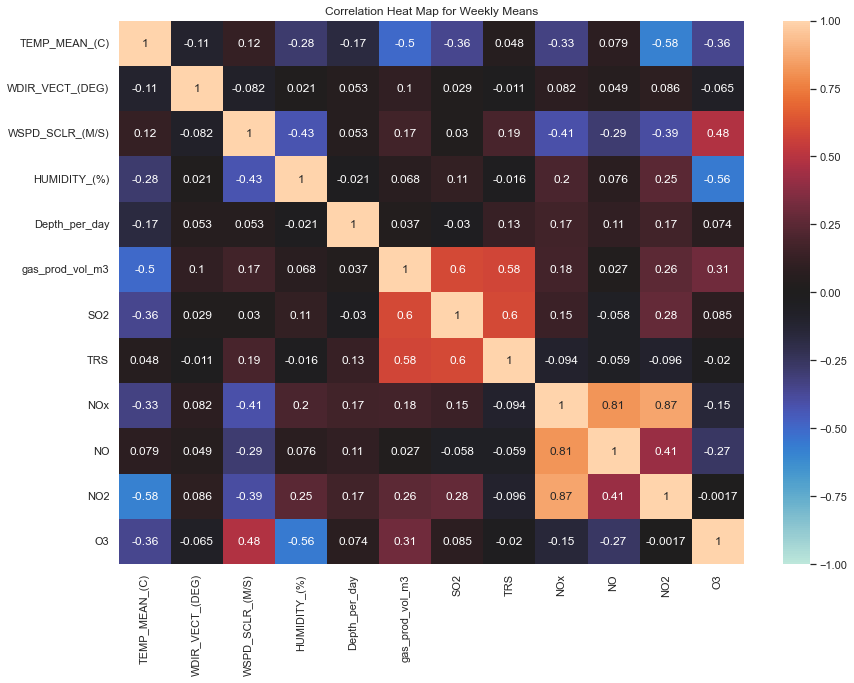

In [9]:
# Re-sample weekly mean for all paramters and plot correlation
week_mean = AQ_weather_drilling_prod_daily.resample('w').mean()

# Make sure to use circ mean when re-sampling wind direction

# Filter out wind direction to apply a circular mean when resampling to daily
WDIR = AQ_weather_hourly.filter(['WDIR_VECT_(DEG)'], axis=1)

def circular_mean(x):
    return round(np.rad2deg(circmean(np.deg2rad(x['WDIR_VECT_(DEG)'].values))),2)

WDIR_weekly = WDIR.resample('w').apply(circular_mean)
week_mean['WDIR_VECT_(DEG)'] = WDIR_weekly

plt.figure(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(week_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Weekly Means')
plt.show()

From the above figure we see that:
SO2:
- stronger negative correlation with temperature compared to daily mean
- stronger positive correlation with gas production compared to daily mean
- no correlation with other variables

TRS:
- Positive correlation with wind speed, depth drilled and gas produced (all stronger than daily mean correlations)

NOx:
- Negative correlation with temperature and wind speed
- Some positive correlation with humidity, depth per day and gas produced

NO:
- Negative correlation with wind speed

NO2:
- Negative correlation with temperature and wind speed
- Positive correlation with humidity, depth per day and gas produced

O3:
- Negative correlation with temperature and humidity
- Positive correlation with gas produced

### Mean Monthly Correlations

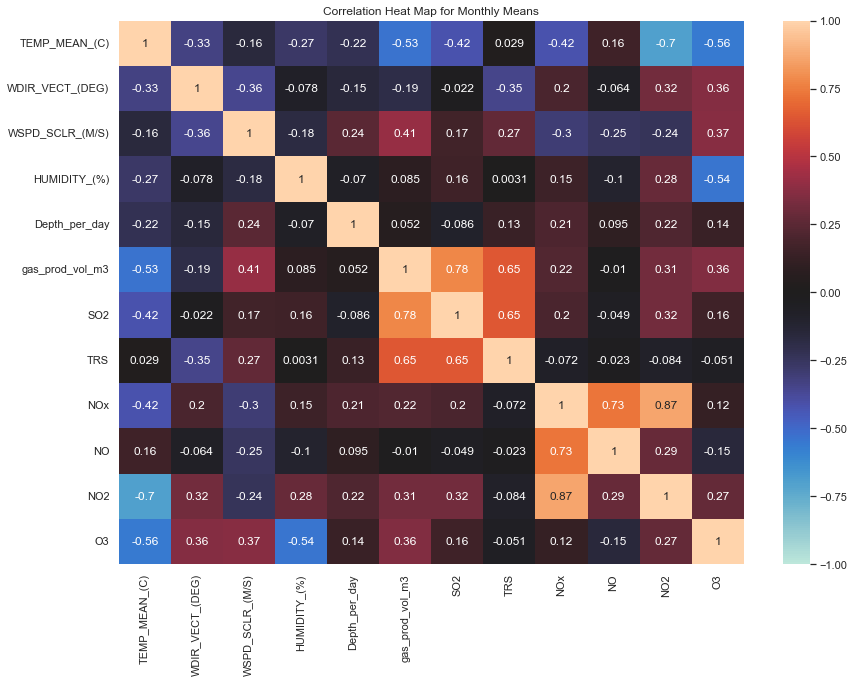

In [10]:
# Re-sample monthly mean for all parameters and plot correlation
month_mean = AQ_weather_drilling_prod_daily.resample('m').mean()

# Make sure to use circ mean when re-sampling wind direction

# Filter out wind direction to apply a circular mean when resampling to daily
WDIR = AQ_weather_hourly.filter(['WDIR_VECT_(DEG)'], axis=1)

def circular_mean(x):
    return round(np.rad2deg(circmean(np.deg2rad(x['WDIR_VECT_(DEG)'].values))),2)

WDIR_monthly = WDIR.resample('m').apply(circular_mean)
month_mean['WDIR_VECT_(DEG)'] = WDIR_monthly

plt.figure(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(month_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.title('Correlation Heat Map for Monthly Means')
plt.show()

From the above figure we see that:
SO2:
- stronger negative correlation with temperature compared to daily and weekly
- stronger positive correlation with gas production compared to daily and weekly mean
- some correlation with wind speed and humidity

TRS:
- Positive correlation with wind speed, depth drilled and gas produced (all stronger than daily and weekly mean correlations)
- Some negative correlation with month mean wind direction

NOx:
- Negative correlation with temperature and wind speed
- Some positive correlation with wind direction, humidity, depth per day and gas produced

NO:
- Negative correlation with wind speed
- some positive correlation with temperature

NO2:
- Negative correlation with temperature and wind speed
- Positive correlation with wind direction, humidity, depth per day and gas produced

O3:
- Negative correlation with temperature and humidity
- Positive correlation with wind direction, wind speed, depth per day and gas produced

## Data Visualization with Scatter Plots
Before fitting any models, the data was visualized using various panelled scatter plots. Four of the pollutants were selected from the heatmaps as they had the most substantial correlations with other parameters. These include SO2, TRS, NO2 and O3. These are shown in monthly and daily scatter plots below.

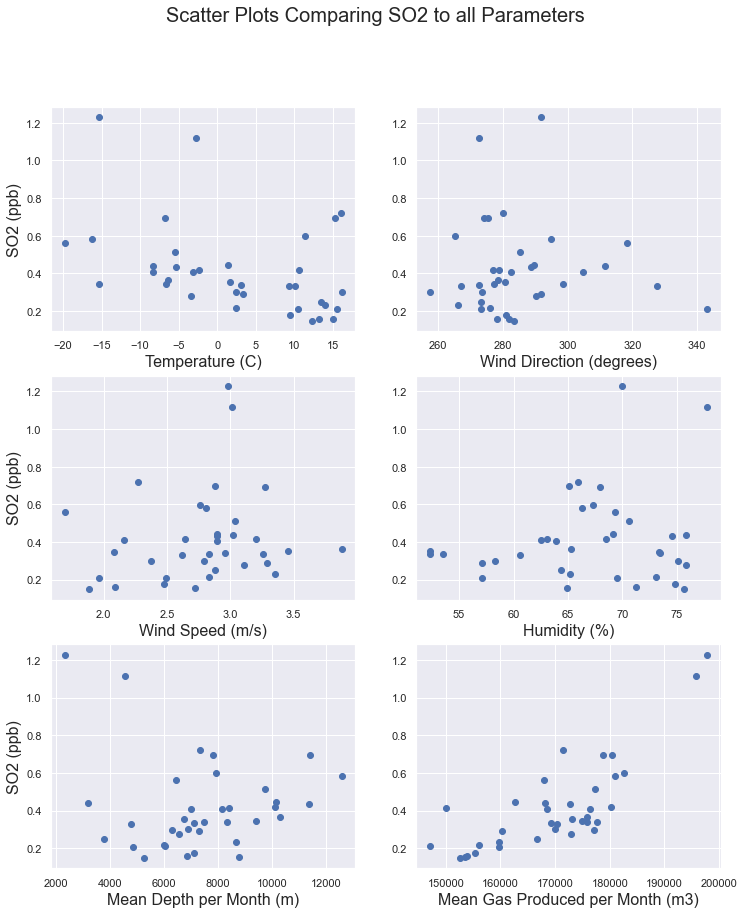

In [11]:
# Plot scatter plot of monthly data for SO2 vs weather and UOG parameters

y = month_mean['SO2']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
sns.set(font_scale=1)
fig.suptitle('Scatter Plots Comparing SO2 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)
#axs[0,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)
#axs[1,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)


plt.show()

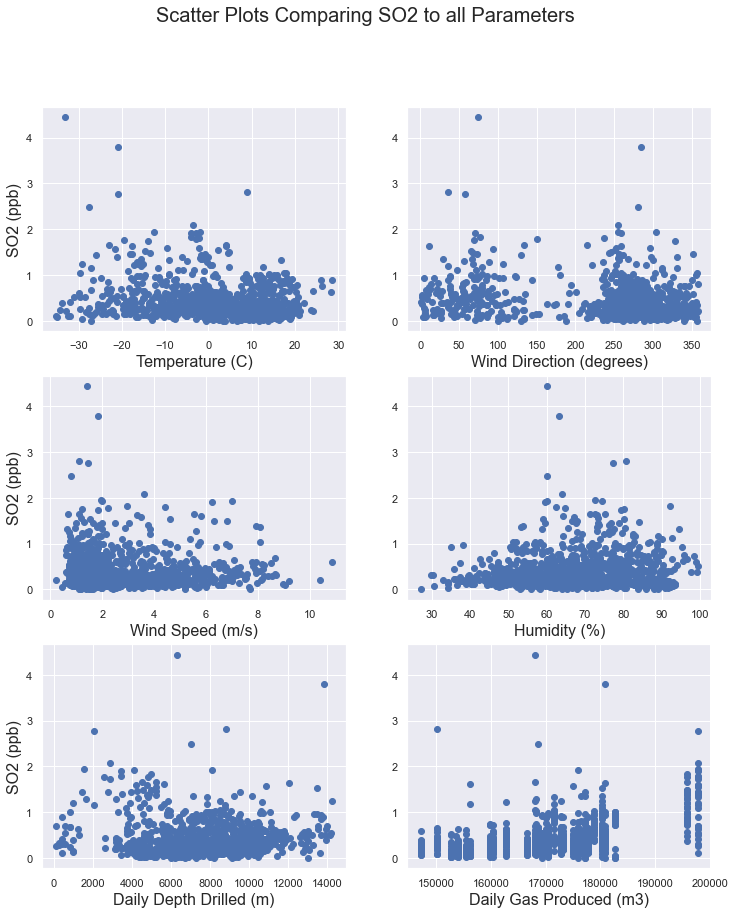

In [12]:
# Plot scatter plot of daily data for SO2 vs weather and UOG parameters

y = AQ_weather_drilling_prod_daily['SO2']

x1 = AQ_weather_drilling_prod_daily['TEMP_MEAN_(C)']
x2 = AQ_weather_drilling_prod_daily['WDIR_VECT_(DEG)']
x3 = AQ_weather_drilling_prod_daily['WSPD_SCLR_(M/S)']
x4 = AQ_weather_drilling_prod_daily['HUMIDITY_(%)']
x5 = AQ_weather_drilling_prod_daily['Depth_per_day']
x6 = AQ_weather_drilling_prod_daily['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
sns.set(font_scale=1)
fig.suptitle('Scatter Plots Comparing SO2 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)
#axs[0,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)
#axs[1,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Daily Depth Drilled (m)', fontsize=16)
axs[2,0].set_ylabel('SO2 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Daily Gas Produced (m3)', fontsize=16)


plt.show()

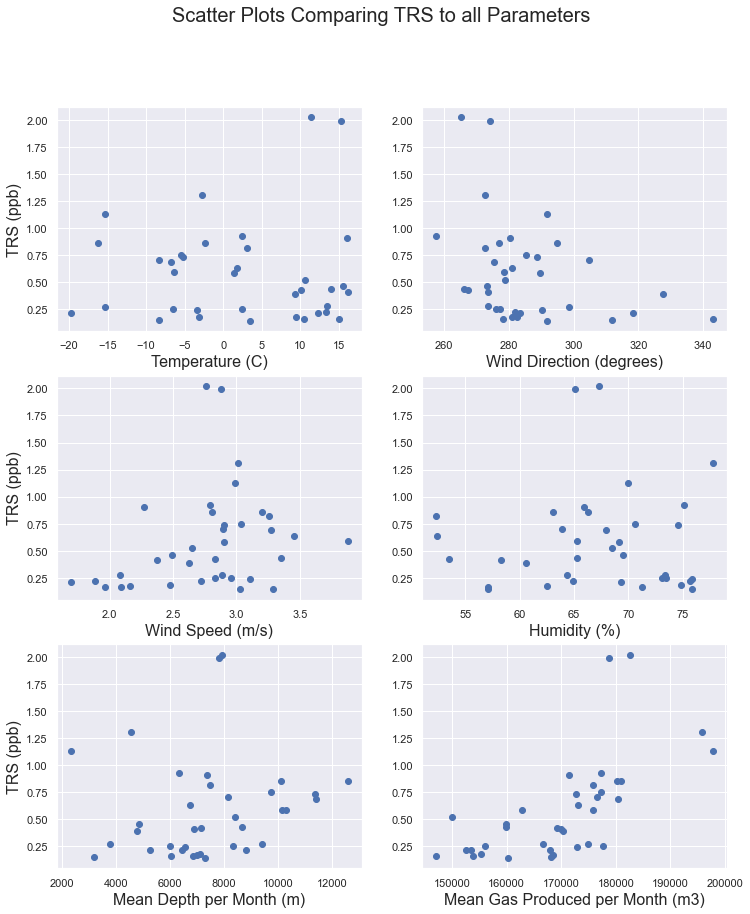

In [13]:
# Plot scatter plot of monthly data for TRS vs weather and UOG parameters

y = month_mean['TRS']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing TRS to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)


plt.show()

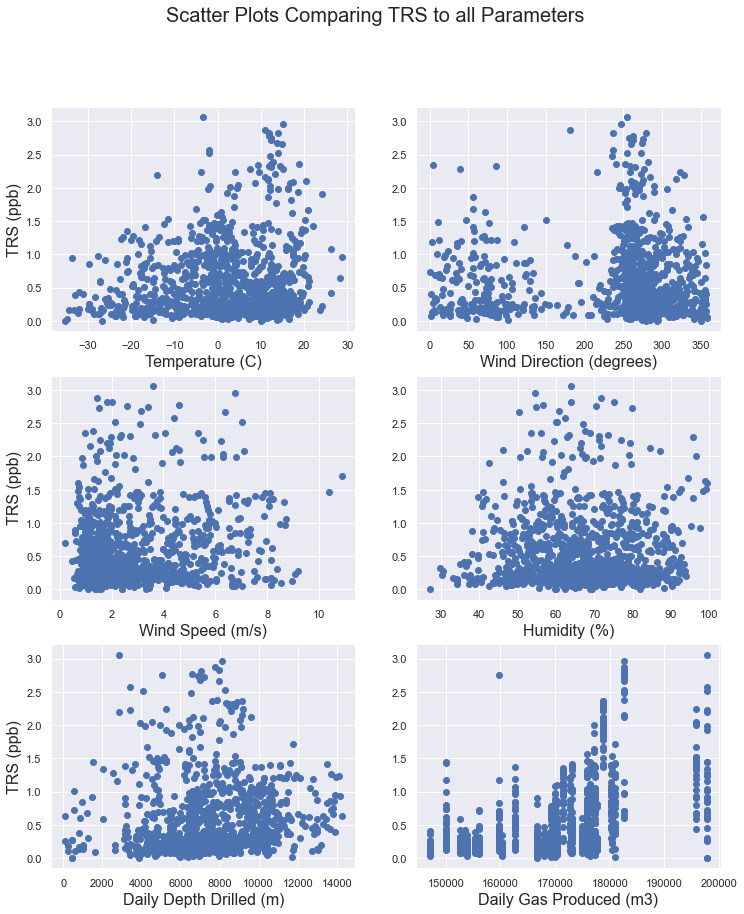

In [14]:
# Plot scatter plot of monthly data for TRS vs weather and UOG parameters

y = AQ_weather_drilling_prod_daily['TRS']

x1 = AQ_weather_drilling_prod_daily['TEMP_MEAN_(C)']
x2 = AQ_weather_drilling_prod_daily['WDIR_VECT_(DEG)']
x3 = AQ_weather_drilling_prod_daily['WSPD_SCLR_(M/S)']
x4 = AQ_weather_drilling_prod_daily['HUMIDITY_(%)']
x5 = AQ_weather_drilling_prod_daily['Depth_per_day']
x6 = AQ_weather_drilling_prod_daily['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing TRS to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Daily Depth Drilled (m)', fontsize=16)
axs[2,0].set_ylabel('TRS (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Daily Gas Produced (m3)', fontsize=16)


plt.show()

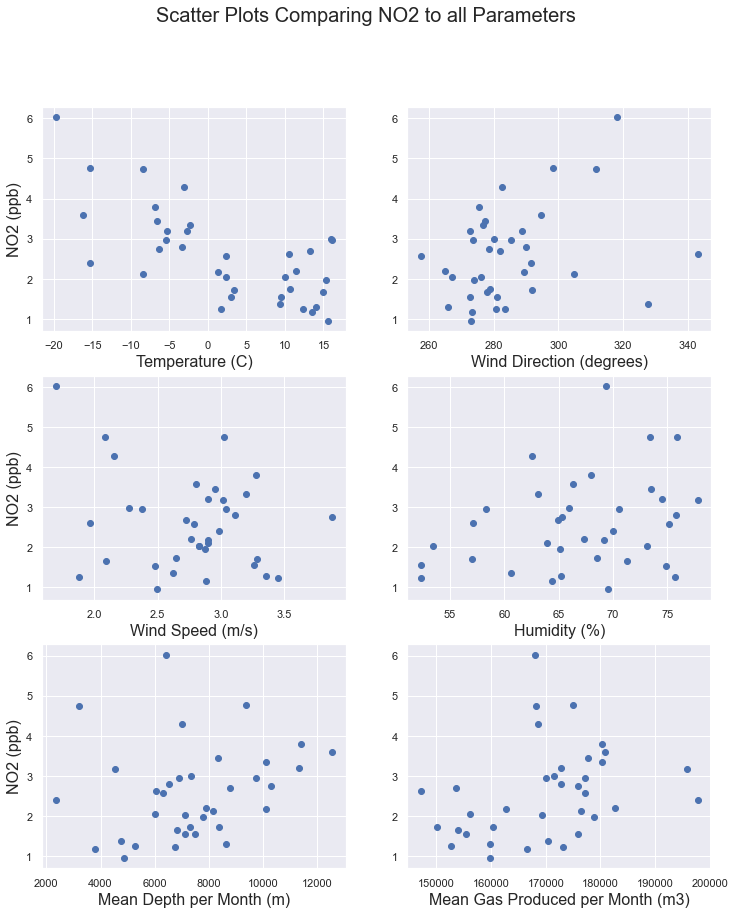

In [15]:
# Plot scatter plot of monthly data for NO2 vs weather and UOG parameters

y = month_mean['NO2']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing NO2 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)

plt.show()

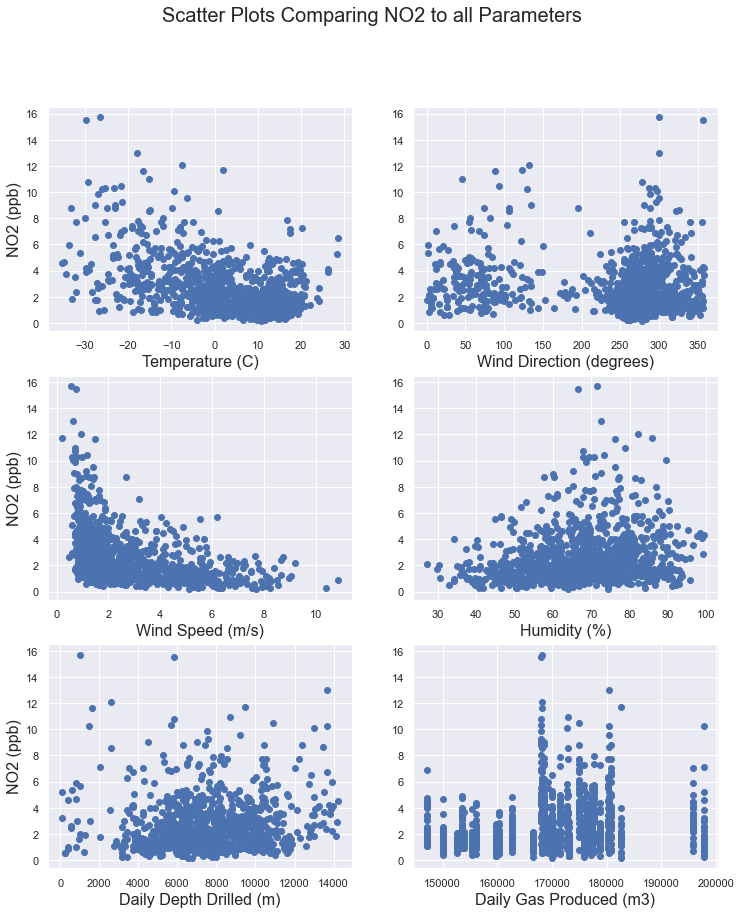

In [16]:
# Plot scatter plot of monthly data for NO2 vs weather and UOG parameters

y = AQ_weather_drilling_prod_daily['NO2']

x1 = AQ_weather_drilling_prod_daily['TEMP_MEAN_(C)']
x2 = AQ_weather_drilling_prod_daily['WDIR_VECT_(DEG)']
x3 = AQ_weather_drilling_prod_daily['WSPD_SCLR_(M/S)']
x4 = AQ_weather_drilling_prod_daily['HUMIDITY_(%)']
x5 = AQ_weather_drilling_prod_daily['Depth_per_day']
x6 = AQ_weather_drilling_prod_daily['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing NO2 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Daily Depth Drilled (m)', fontsize=16)
axs[2,0].set_ylabel('NO2 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Daily Gas Produced (m3)', fontsize=16)

plt.show()

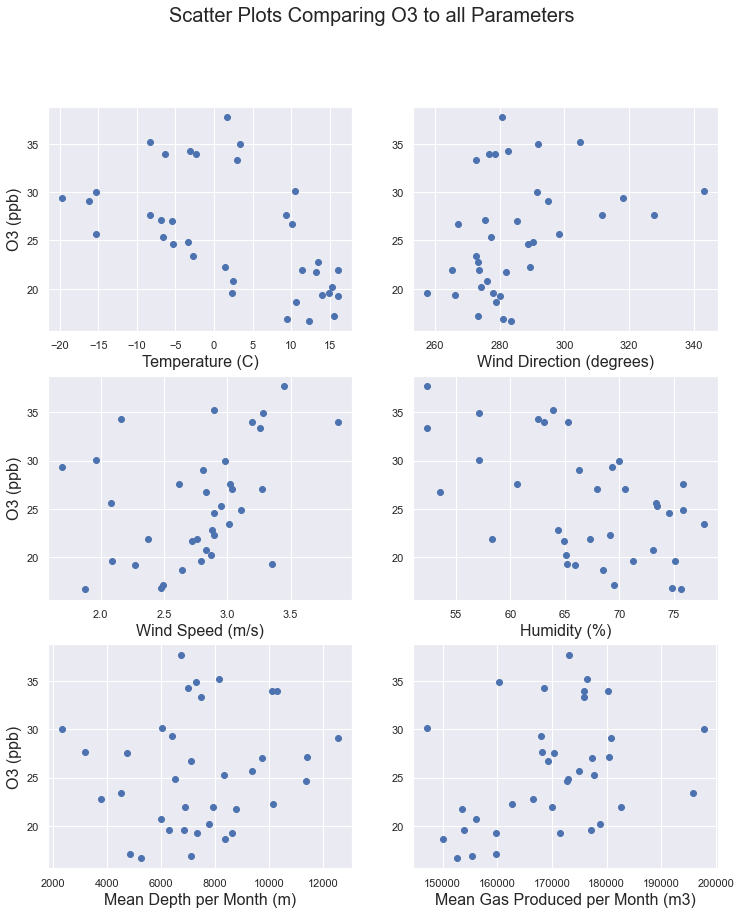

In [17]:
# Plot scatter plot of monthly data for O3 vs weather and UOG parameters

y = month_mean['O3']

x1 = month_mean['TEMP_MEAN_(C)']
x2 = month_mean['WDIR_VECT_(DEG)']
x3 = month_mean['WSPD_SCLR_(M/S)']
x4 = month_mean['HUMIDITY_(%)']
x5 = month_mean['Depth_per_day']
x6 = month_mean['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing O3 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)
#axs[0,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)
#axs[1,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Mean Depth per Month (m)', fontsize=16)
axs[2,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Mean Gas Produced per Month (m3)', fontsize=16)


plt.show()

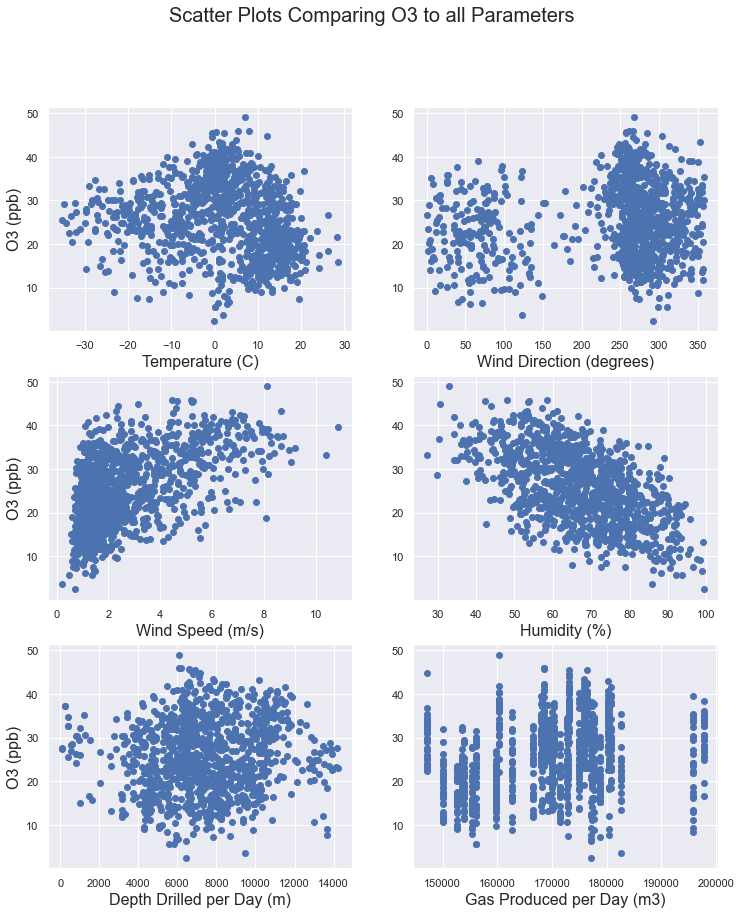

In [18]:
# Plot scatter plot of monthly data for O3 vs weather and UOG parameters

y = AQ_weather_drilling_prod_daily['O3']

x1 = AQ_weather_drilling_prod_daily['TEMP_MEAN_(C)']
x2 = AQ_weather_drilling_prod_daily['WDIR_VECT_(DEG)']
x3 = AQ_weather_drilling_prod_daily['WSPD_SCLR_(M/S)']
x4 = AQ_weather_drilling_prod_daily['HUMIDITY_(%)']
x5 = AQ_weather_drilling_prod_daily['Depth_per_day']
x6 = AQ_weather_drilling_prod_daily['gas_prod_vol_m3']

#sns.set(font_scale=1)

fig, axs = plt.subplots(3,2, figsize=(12,14))
fig.suptitle('Scatter Plots Comparing O3 to all Parameters', fontsize=20)

axs[0,0].scatter(x1,y)
axs[0,0].set_xlabel('Temperature (C)', fontsize=16)
axs[0,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[0,1].scatter(x2,y)
axs[0,1].set_xlabel('Wind Direction (degrees)', fontsize=16)
#axs[0,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[1,0].scatter(x3,y)
axs[1,0].set_xlabel('Wind Speed (m/s)', fontsize=16)
axs[1,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[1,1].scatter(x4,y)
axs[1,1].set_xlabel('Humidity (%)', fontsize=16)
#axs[1,1].set_ylabel('SO2 (ppb)', fontsize=16)

axs[2,0].scatter(x5,y)
axs[2,0].set_xlabel('Depth Drilled per Day (m)', fontsize=16)
axs[2,0].set_ylabel('O3 (ppb)', fontsize=16)
axs[2,1].scatter(x6,y)
axs[2,1].set_xlabel('Gas Produced per Day (m3)', fontsize=16)

plt.show()

In [20]:
# Export combined dataframes for model development
AQ_weather_drilling_prod_daily.to_csv('daily_mean.csv')
month_mean.to_csv('month_mean.csv')